# Webscraping

In [1]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import shutil
import requests
import os

Le code importe les images de prévisualisation ou _thumbnails_ dans un dossier **../training_data/raw**. On cherche à importer des exemplaires des images suivantes :

* Campanula persicifolia L. https://identify.plantnet.org/species/salad/Campanula%20persicifolia%20L.
* Cichorium intybus L. https://identify.plantnet.org/species/salad/Cichorium%20intybus%20L. 
* Lepidium draba L. https://identify.plantnet.org/species/salad/Lepidium%20draba%20L.
* Leucanthemum vulgare (Vaill.) Lam. https://identify.plantnet.org/species/salad/Leucanthemum%20vulgare%20(Vaill.)%20Lam.
* Malva sylvestris L. https://identify.plantnet.org/species/salad/Malva%20sylvestris%20L.


In [2]:
FLOWER_URL = {
    'Campanula persicifolia L.': 'https://identify.plantnet.org/species/salad/Campanula%20persicifolia%20L.',
    'Cichorium intybus L.': 'https://identify.plantnet.org/species/salad/Cichorium%20intybus%20L.' ,
    'Lepidium draba L.' :'https://identify.plantnet.org/species/salad/Lepidium%20draba%20L.',
    'Leucanthemum vulgare (Vaill.) Lam.' : 'https://identify.plantnet.org/species/salad/Leucanthemum%20vulgare%20(Vaill.)%20Lam.',
    'Malva sylvestris L.': 'https://identify.plantnet.org/species/salad/Malva%20sylvestris%20L.'
}

Comme navigateur, on utilisera Firefox par défaut. Le code assume que `geckodriver` est soit installé à la racine du projet ou dans le PATH

In [ ]:
browser = webdriver.Firefox()

Le programme principal sera accompagné de deux fonctions :

Une fonction pour naviguer sur l'URL dans les valeurs de `FLOWER_URL`, appelée `navigate_to_images`. La fonction prend en entrée le lien et ordonne au navigateur de trouver l'icône en forme de fleur et de cliquer dessus.

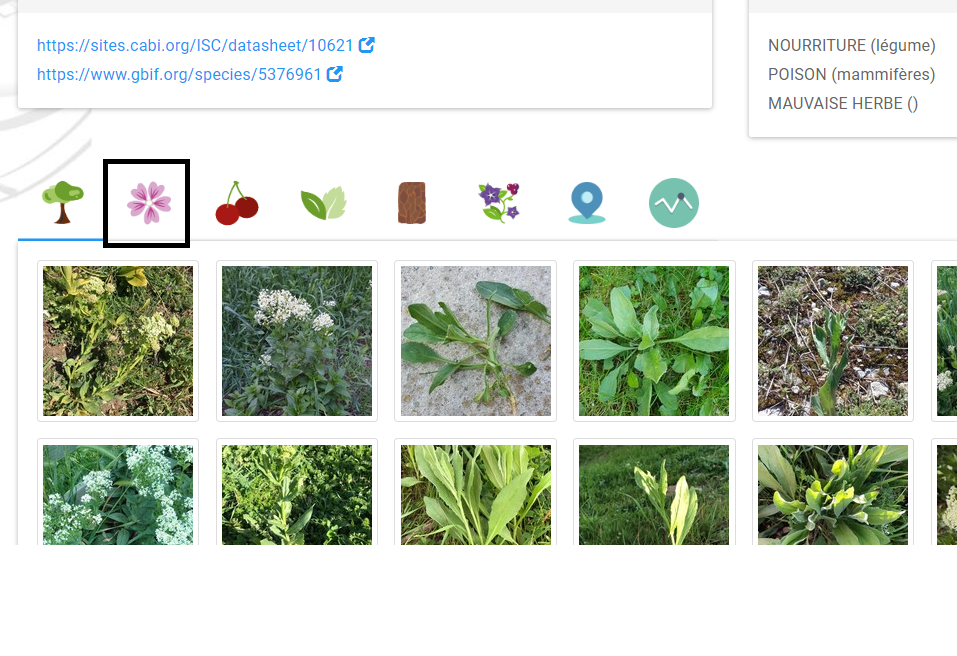

Il va ensuite prendre le lien des prévisualisations, ayant un sélecteur CSS en commun, et renvoie une liste contenant le lien vers les images.

La fonction `download_image` va prendre chaque lien, obtenir le corps de la réponse et les sauvegarder dans une image intitulée `img_{i}.jpg`.

In [ ]:
#Télécharge les images dans le dossier
def download_image(links):
    for i, link in enumerate(links):
        response = requests.get(link, stream=True)
        with open(f'{dirname}/img_{i}.jpg', 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
        del response

# Navigue sur la page URL et récupère les images dessus
def navigate_to_images(url):
    browser.get(url)
    #Marque une pause pour que l'élément en forme d'icône de fleur soit visible
    pause = WebDriverWait(browser, 10).until(EC.visibility_of_element_located((By.XPATH, "/html/body/div/div/div/div[2]/ul/li[2]/a/img")))
    #Clique sur l'icône fleur pour afficher les images en forme de fleur
    flower_icon = browser.find_element_by_xpath('/html/body/div/div/div/div[2]/ul/li[2]/a/img')
    flower_icon.click()

    #Marque une pause de 1:15 maximum pour que toutes les images soient disponibles
    pause = WebDriverWait(browser, 75).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR , "img.img.img-responsive.img-thumbnail")))
    
    #Capture tous les éléments web ayant une prévisualisation d'image et prend les liens
    flowers = browser.find_elements_by_css_selector("img.img.img-responsive.img-thumbnail")
    return [flower.get_attribute("src") for flower in flowers]

Le code principal va créer un nouveau dossier si il n'existe pas, et va exécuter `navigate_to_images`, puis `download_images` successivement pour stocker toutes les images. Si le dossier existe mais qu'il n'est pas rempli, le code reprend le scraping à partir de la dernière image récupérée.

In [ ]:
#Itère sur chacun des noms et des liens
for name, url in FLOWER_URL.items():

    #Crée un nouveau répertoire pour stocker les images si il n'existe pas
    dirname = "raw/" + name.replace(" ", "_").replace(".","")
    if not os.path.exists(dirname):
        os.makedirs(dirname)

        img_links = navigate_to_images(url)

        download_image(img_links)
    else:
        img_links = navigate_to_images(url)
        #Vérifie si toutes les images sont là, sinon itère sur le reste
        if len(os.listdir(dirname)) < len(img_links):
            img_links = img_links[len(os.listdir(dirname)):]
            download_image(img_links)


Enfin, on ferme le navigateur pour sécuriser le bon fonctionnement du processus

In [ ]:
browser.close()

**NOTE :** Le scrapping peut s'avérer difficile à cause des problèmes de connexion du site. Il est don